In [13]:
import pandas as pd
import numpy as np
import os

In [14]:
import matplotlib as mpl

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

import seaborn as sns

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression



In [15]:
from pylab import rcParams
plt.style.use('seaborn')

# Manipulación base de datos del INE

Primero crearemos un dataframe a partir de la base de datos del IPC proporcionada por el INE

In [16]:
input_file_path = "../SRC/IPC-INE/" 
output_file_path = "./Sheets/"

excel_file_list = os.listdir(input_file_path)
df = pd.DataFrame()

for excel_files in excel_file_list:
    if excel_files.endswith(".xls"):
        df1 = pd.read_excel(input_file_path+excel_files)
        df = pd.concat([df,df1],axis=0)


#df.to_excel(output_file_path+"IPC 2011-2022 SUCIO.xlsx")

In [17]:
df.head()

,Código,Descripción
0,0,Índice general
1,1,Alimentos y bebidas no alcohólicas ...
2,111101,Arroz ...
3,111201,Harina ...
4,111202,Maíz ...


El dataframe tiene columnas repetidas por nomenclatura irregular\
En nuestro caso solo nos interesan las columnas:

* (0)   Año
* (1)   Mes
* (2,13)   Código
* (3,14)   Descripción
* (4,15)   República

In [18]:
Col_CODIGO = [2,13]
Col_Descripcion = [3,14]
Col_Republica = [4,15]


df_limpio = df[df.columns[[0,1]].to_list()].copy()

tmp_name = str(df.columns[Col_Descripcion[0]])
#df_limpio[tmp_name] = (df[df.columns[Col_Descripcion[0]]].fillna('')) + (df[df.columns[Col_Descripcion[1]]].fillna(''))

for pareja_numerica in [Col_CODIGO,Col_Republica]:
    tmp_name = str(df.columns[pareja_numerica[0]])
    df_limpio[tmp_name] = df[df.columns[[pareja_numerica[0],pareja_numerica[1]]]].sum(axis=1,numeric_only=True) 


df_limpio


IndexError: index 3 is out of bounds for axis 0 with size 2

Para reorganizar, colocar códigos como enteros (sin decimal) y cambiar los meses de texto a número

In [ ]:
#df_limpio.columns[[i for i in range(0,len(df_limpio.columns))]].to_list()

def mes_a_numero(mes:str):
    if mes.lower() == "enero":
        return 1
    if mes.lower() == "febrero":
        return 2
    if mes.lower() == "marzo":
        return 3
    if mes.lower() == "abril":
        return 4
    if mes.lower() == "mayo":
        return 5
    if mes.lower() == "junio":
        return 6
    if mes.lower() == "julio":
        return 7
    if mes.lower() == "agosto":
        return 8
    if mes.lower() == "septiembre":
        return 9
    if mes.lower() == "octubre":
        return 10
    if mes.lower() == "noviembre":
        return 11
    if mes.lower() == "diciembre":
        return 12

mes_lista_numero = []

for mes_lista in df_limpio["Mes"].to_list():
    mes_lista_numero.append(mes_a_numero(mes_lista))
    
df_limpio["Mes"]=mes_lista_numero
df_limpio["CODIGO"]=df_limpio["CODIGO"].astype(int)

In [ ]:
df_limpio.head()

,Año,Mes,CODIGO,República
0,2011,4,0,103.17
1,2011,4,1,105.01
2,2011,4,111101,101.69
3,2011,4,111201,109.18
4,2011,4,111202,134.26


In [ ]:
df_limpio.to_excel(output_file_path+"IPC 2011-2022 LIMPIO.xlsx")

Este bloque sirve para crear un dataframe que contenga los códigos de cada componente del IPC y su descripción

In [ ]:
Lista_Codigos = list(set(df_limpio["CODIGO"].to_list()))
Lista_Descripciones =[]

for i in range(len(Lista_Codigos)):
    Lista_Descripciones.append(list(set(df_limpio[df_limpio["CODIGO"]==Lista_Codigos[i]]["DESCRIPCION"]))[0].lower())

df_Codigos = pd.DataFrame({"CODIGO":Lista_Codigos,"DESCRIPCION":Lista_Descripciones})
df_Codigos =df_Codigos.sort_values(by=["CODIGO"])

df_Codigos.set_index("CODIGO",inplace=True)

NameError: name 'df_limpio' is not defined

In [ ]:
df_Codigos

,DESCRIPCION
CODIGO,
0,índice general
1,alimentos y bebidas no alcohólicas ...
2,bebidas alcohólicas y tabaco ...
3,prendas de vestir y calzado ...
4,"vivienda, agua, electricidad, gas y otros comb..."
...,...
1251101,servicio de emisión de certificado de todo tip...
1251102,servicio de fotocopiado ...
1251103,servicio notarial ...


In [ ]:
df_Codigos.to_excel(output_file_path+"Tabla codigos.xlsx")

In [ ]:
#con el comando .loc[] se puede conocer la descripción correspondiente a cada código

df_Codigos.loc[115201]

DESCRIPCION    aceites                                       ...
Name: 115201, dtype: object

Creando la columna de fechas para las series de tiempo

In [ ]:
df_fecha = pd.DataFrame()

df_fecha["Fecha"]=pd.date_range(start=str(df_limpio["Año"].min())+"-"+str(df_limpio[df_limpio["Año"]==df_limpio["Año"].min()]["Mes"].min()),end=str(df_limpio["Año"].max())+"-"+str(df_limpio[df_limpio["Año"]==df_limpio["Año"].max()]["Mes"].max()),freq="MS")
#df_trabajo.set_index("Fecha")

df_trabajo = df_fecha.copy()
df_trabajo

,Fecha
0,2011-04-01
1,2011-05-01
2,2011-06-01
3,2011-07-01
4,2011-08-01
...,...
133,2022-05-01
134,2022-06-01
135,2022-07-01
136,2022-08-01


Muy bien, ahora se puede hacer un data frame donde cada integrante del IPC (código) represente una columna

In [ ]:
for Codigo in list(df_Codigos.index.values):   
        
    df_temp = pd.DataFrame({str(Codigo):df_limpio[df_limpio["CODIGO"]==Codigo]["República"].to_list()})
    df_trabajo = pd.concat([df_trabajo,df_temp],axis=1)

#df_trabajo


In [ ]:
df_trabajo

,0,1,2,3,4,5,6,7,8,9,...,1222101,1222102,1222103,1231101,1241101,1251101,1251102,1251103,1251104,1251105
Fecha,,,,,,,,,,,,,,,,,,,,,
2011-04-01,103.17,105.01,101.43,100.78,103.99,101.12,101.30,106.80,100.68,100.79,...,100.45,100.28,100.70,103.23,100.15,100.00,100.06,99.93,100.40,100.51
2011-05-01,103.68,105.71,102.15,101.07,105.21,101.39,101.62,107.25,100.77,100.49,...,100.46,100.28,100.70,103.33,100.46,100.00,100.10,100.11,100.03,100.51
2011-06-01,104.23,107.76,103.59,101.42,104.26,101.60,101.79,106.68,100.84,100.90,...,100.39,100.32,100.73,103.33,100.37,100.00,100.69,100.34,100.03,103.93
2011-07-01,105.22,110.66,104.82,101.72,104.42,101.78,101.98,106.85,100.83,101.15,...,100.43,100.32,101.01,103.46,100.04,100.00,100.69,100.34,100.14,103.93
2011-08-01,105.85,112.13,105.20,102.01,104.92,102.25,102.24,107.26,100.77,101.08,...,101.11,100.64,101.01,103.48,100.11,100.00,100.71,100.34,100.43,103.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-01,158.98,241.12,121.47,115.58,123.62,124.79,130.32,146.13,110.99,120.69,...,108.77,110.26,109.15,137.76,95.10,119.54,123.81,113.64,129.08,127.83
2022-06-01,161.89,249.55,122.79,115.93,123.77,125.95,130.98,146.82,111.88,121.02,...,109.15,110.55,109.19,137.76,95.30,119.54,124.29,114.58,129.79,127.83
2022-07-01,163.64,255.47,123.65,116.20,124.01,127.20,131.26,144.09,111.87,121.72,...,109.12,110.78,109.56,137.76,95.30,119.54,124.70,114.58,129.97,127.83


En esta tabla se encuentran expresados como series de tiempo todos los componentes del IPC a nivel república

In [ ]:
df_trabajo = df_trabajo.replace(0,np.nan)

In [ ]:
df_trabajo.loc[pd.to_datetime("2010-12-01")]=[100 for i in range(0,len(df_trabajo.columns))]


for i in [1,2,3]:
    df_trabajo.loc[pd.to_datetime("2011-"+str(i)+"-01")]=[np.nan for i in range(0,len(df_trabajo.columns))]

df_trabajo

,0,1,2,3,4,5,6,7,8,9,...,1222101,1222102,1222103,1231101,1241101,1251101,1251102,1251103,1251104,1251105
Fecha,,,,,,,,,,,,,,,,,,,,,
2011-04-01,103.17,105.01,101.43,100.78,103.99,101.12,101.30,106.80,100.68,100.79,...,100.45,100.28,100.70,103.23,100.15,100.00,100.06,99.93,100.40,100.51
2011-05-01,103.68,105.71,102.15,101.07,105.21,101.39,101.62,107.25,100.77,100.49,...,100.46,100.28,100.70,103.33,100.46,100.00,100.10,100.11,100.03,100.51
2011-06-01,104.23,107.76,103.59,101.42,104.26,101.60,101.79,106.68,100.84,100.90,...,100.39,100.32,100.73,103.33,100.37,100.00,100.69,100.34,100.03,103.93
2011-07-01,105.22,110.66,104.82,101.72,104.42,101.78,101.98,106.85,100.83,101.15,...,100.43,100.32,101.01,103.46,100.04,100.00,100.69,100.34,100.14,103.93
2011-08-01,105.85,112.13,105.20,102.01,104.92,102.25,102.24,107.26,100.77,101.08,...,101.11,100.64,101.01,103.48,100.11,100.00,100.71,100.34,100.43,103.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-01,165.35,258.28,125.38,116.79,127.21,128.83,131.79,144.77,111.70,122.48,...,109.29,111.10,109.78,137.76,95.49,119.54,127.42,115.43,129.92,127.83
2010-12-01,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,...,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
2011-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_trabajo = df_trabajo.sort_index(ascending=True)

In [ ]:
#type(df_trabajo.isnull().sum()[df_trabajo.isnull().sum()>3])
#df_trabajo.isnull().sum()[df_trabajo.isnull().sum()>3]
col_eliminar = (df_trabajo.isnull().sum()[df_trabajo.isnull().sum()>3]).index.to_list()

In [ ]:
col_eliminar

[]

In [ ]:
for col in col_eliminar:
    df_trabajo.drop(col,axis=1,inplace=True)

Con esto se tienen las series de tiempo disponibles proporcionadas por el INE, ahora falta imputar los datos de enero a marzo de 2011

In [ ]:
tasas_variacion=(df_trabajo.loc[pd.to_datetime("2011-04-01")]-df_trabajo.loc[pd.to_datetime("2010-12-01")])/df_trabajo.loc[pd.to_datetime("2010-12-01")]
tasas_variacion

0          0.0317
1          0.0501
2          0.0143
3          0.0078
4          0.0399
            ...  
1251101    0.0000
1251102    0.0006
1251103   -0.0007
1251104    0.0040
1251105    0.0051
Length: 292, dtype: float64

In [ ]:
#incremento_mensual = np.exp(np.log(1+tasas_variacion)/12)
incremento_mensual = pd.Series.pow(1+tasas_variacion,1/4)
incremento_mensual

0          1.007832
1          1.012296
2          1.003556
3          1.001944
4          1.009829
             ...   
1251101    1.000000
1251102    1.000150
1251103    0.999825
1251104    1.000999
1251105    1.001273
Length: 292, dtype: float64

In [ ]:
for i in [1,2,3]:
    df_trabajo.loc[pd.to_datetime("2011-"+str(i)+"-01")]=df_trabajo.loc[pd.to_datetime("2010-12-01")]*pd.Series.pow(incremento_mensual,i)

In [ ]:
df_trabajo.head()

,0,1,2,3,4,5,6,7,8,9,...,1222101,1222102,1222103,1231101,1241101,1251101,1251102,1251103,1251104,1251105
Fecha,,,,,,,,,,,,,,,,,,,,,
2010-12-01,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.000000,100.000000,100.00000,100.000000
2011-01-01,100.783250,101.229634,100.355599,100.194432,100.982913,100.278832,100.323428,101.658293,100.169568,100.196918,...,100.112311,100.069927,100.174542,100.797899,100.037479,100.0,100.014997,99.982495,100.09985,100.127257
2011-02-01,101.572634,102.474387,100.712462,100.389242,101.975487,100.558441,100.647901,103.344085,100.339424,100.394223,...,100.224747,100.139902,100.349390,101.602165,100.074972,100.0,100.029996,99.964994,100.19980,100.254676
2011-03-01,102.368201,103.734446,101.070594,100.584431,102.977818,100.838829,100.973424,105.057833,100.509568,100.591917,...,100.337311,100.209927,100.524542,102.412848,100.112479,100.0,100.044997,99.947495,100.29985,100.382257
2011-04-01,103.170000,105.010000,101.430000,100.780000,103.990000,101.120000,101.300000,106.800000,100.680000,100.790000,...,100.450000,100.280000,100.700000,103.230000,100.150000,100.0,100.060000,99.930000,100.40000,100.510000


In [ ]:
#df_trabajo.to_excel(output_file_path+"Base_datos.xlsx")

# Creación series de tiempo de inflación

In [ ]:
df_inflacion = df_trabajo.pct_change(periods=12)

In [ ]:
x = df_inflacion.iloc[12:,1:13] # 13: para tomar todos los gastos, 1:13 para tomar las divisiones
y = df_inflacion.iloc[12:,0]

# Inflación subyacente del banguat

In [ ]:
df_excel_subyacente_banguat = pd.read_excel("./información Banguat/subyacente.xlsx",usecols="B:W",header=6,nrows=12)
df_subyacente_banguat = pd.DataFrame()
for i in range(2012,2023):
    #print(i)
    df_temp = df_excel_subyacente_banguat[i]
    #df_subyactente = df_subyactente.append(df_temp,ignore_index=True)
    df_subyacente_banguat = pd.concat([df_subyacente_banguat,df_temp],axis=0)

df_subyacente_banguat = pd.concat([pd.Series(df_excel_subyacente_banguat[2011].values[-1]),df_subyacente_banguat],axis=0) #esto añade el valor de 12/2011
df_subyacente_banguat.dropna(axis=0,inplace=True)#elimina las filas con valores nulos
df_subyacente_banguat["Fecha"]=y.index
df_subyacente_banguat.set_index("Fecha",inplace=True)
df_subyacente_banguat=df_subyacente_banguat/100

# HACIENDO PCA

In [ ]:
x_norm = StandardScaler().fit_transform(x)
#x_norm = StandardScaler(with_std=False).fit_transform(x)

In [ ]:
(x_norm - x.apply(lambda x: (x-np.mean(x))/np.std(x)).values <= 1e-5).all()

True

In [ ]:
pca = decomposition.PCA(n_components=12) #max 12, por ser las observaciones, pero se obseva que con 4 componentes se puede obtener una buena aproximación
pc=pca.fit_transform(x_norm)

In [ ]:
df_pca = pd.DataFrame({"var":pca.explained_variance_ratio_,"PC":["PC"+str(i) for i in range(1,len(pca.components_)+1)]})

In [ ]:
df_pca["var"]=df_pca["var"]*100

<Figure size 800x550 with 0 Axes>

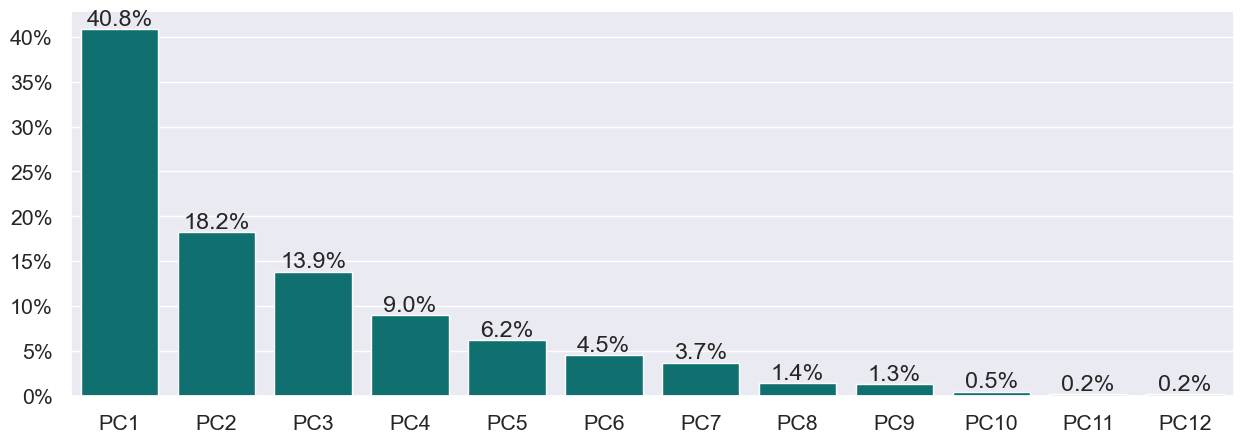

In [ ]:
from unicodedata import decimal
import matplotlib.ticker as mtick

plt.figure()
plt.figure(figsize=(15, 5))
sns.set(font_scale=1.4)
ax=sns.barplot(x="PC",y="var",data=df_pca,color="teal")

#plt.title('Proporción de varianza explicada', fontsize=24)
#plt.xlabel('Componentes principales', fontsize=18)
plt.xlabel('', fontsize=18)
plt.ylabel(None)
plt.gca().get_yaxis().set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.bar_label(ax.containers[0],fmt='%2.1f%%')
plt.savefig(".\Graficas\prop_var.jpg",bbox_inches='tight')
plt.show()

In [ ]:
df_pc = pd.DataFrame(pc,columns=["PC"+str(i) for i in range(1,len(pca.components_)+1)])
df_pc.set_index(y.index,inplace=True)
df_pc

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
Fecha,,,,,,,,,,,,
2011-12-01,3.183760,0.571006,-0.019872,-0.284294,2.993110,0.201332,-0.550268,0.367741,0.612573,-0.134891,0.148829,-0.154653
2012-01-01,3.246264,0.144531,0.137397,-0.091295,2.335626,0.025653,-0.904214,0.534197,0.950534,0.070190,0.141958,-0.092093
2012-02-01,3.273735,0.342234,0.203364,0.253366,2.413024,-0.387150,-0.469205,0.630246,0.589147,0.088314,0.131258,-0.166652
2012-03-01,3.150105,0.323895,-0.050151,0.624950,2.167609,-0.742047,0.063701,0.650970,0.464700,-0.021153,0.292119,-0.213239
2012-04-01,3.282470,0.370886,-0.462962,0.835593,1.438255,-1.137058,0.262849,0.254685,0.033179,0.137221,0.407499,-0.217451
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-01,2.831865,3.180353,-1.636875,0.309866,-0.885472,0.499517,-0.167787,0.202265,0.061202,0.174966,0.115438,0.205061
2022-06-01,4.079368,3.234158,-2.127322,0.621729,0.530424,1.065104,0.100434,-0.008948,-0.167886,0.229244,-0.088398,0.123470
2022-07-01,5.089597,2.950890,-2.670897,0.606746,0.933226,1.387620,-0.166154,-0.059454,-0.486133,0.446182,-0.252107,0.069528


Por lo que el factor común Ft, se obtiene con este PCA

$ F_t = PC1_{escalado}$

Es necesario escalar el componente principal de nuevo porque este se encuentra normalizado, esto se hará con la desviación estándar y media de la variación interanual del nivel general de precios a nivel república

Por lo que, para obtener un estimado de la inflación de cada componente del CPI:

$\pi_{i,t}=\Lambda_i F_t + \epsilon_{i,t}$

The measure of core inflation based on the common component, CPI-common, is defined and calculated as **the series of predicted values from the simple linear regression of the annual inflation rates of the All-items CPI** excluding the effect of changes in indirect taxes (obtained in Step 1) on an intercept and on the first principal component

# Mostrando regresiones con todos los componentes

C:\Users\Juan_Manuel\AppData\Local\Temp\ipykernel_14104\3623372758.py:22: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm)


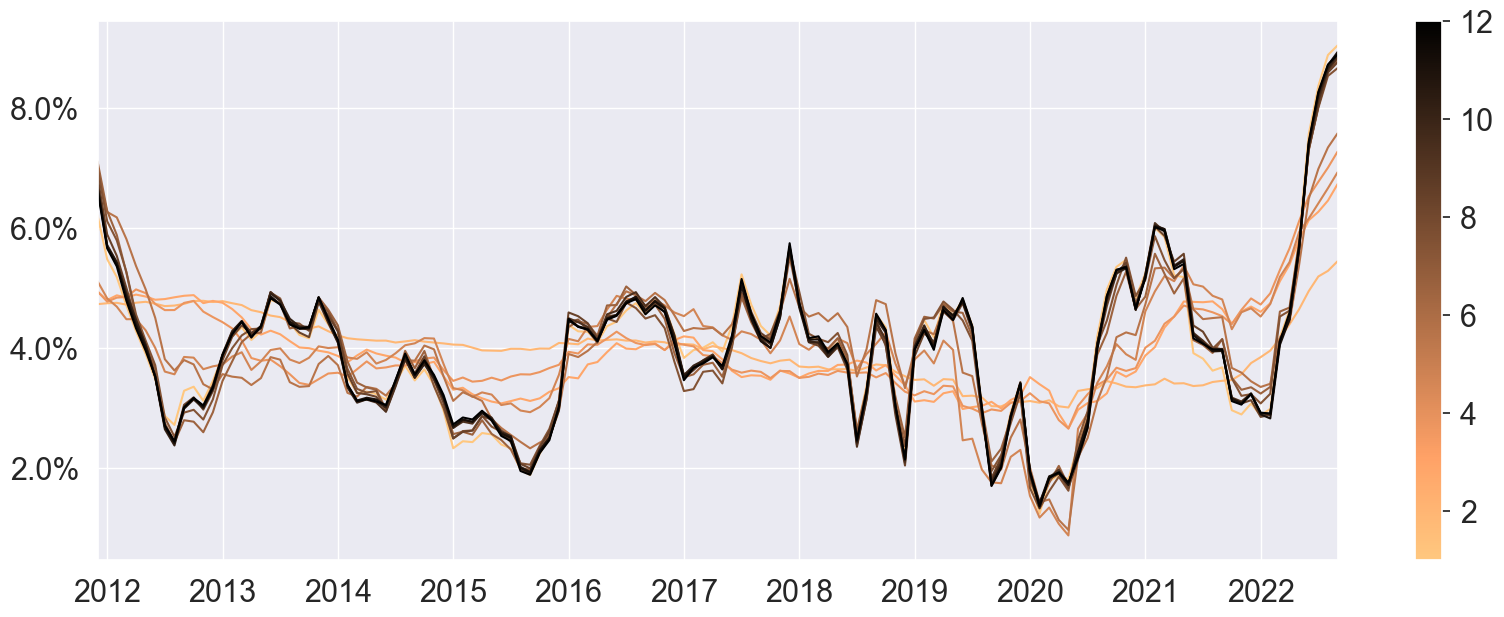

In [ ]:
slr=LinearRegression()

df_componentes = y.copy()

for i in range(len(df_pc.columns)):
    df_Ft=df_pc.iloc[:,:i+1].multiply(y.std()).add(y.mean()) 
    #print(df_Ft)
    x_reg = df_Ft.values
    y_reg=y.values.reshape(-1,1)
    df_estimacion = pd.DataFrame(slr.fit(x_reg,y_reg).predict(x_reg))
    df_estimacion["Fecha"]=y.index
    df_estimacion.set_index("Fecha",inplace=True)

    #print(df_estimacion)
    df_componentes = pd.concat([df_componentes,df_estimacion],axis=1)


sns.set(font_scale=2)
sm = plt.cm.ScalarMappable(cmap="copper_r", norm=plt.Normalize(vmin=1, vmax=12))
sm._A=[]
plot = df_componentes.plot(legend=False,cmap="copper_r", figsize=(20, 7),xlabel="")
cbar=plt.colorbar(sm)
#cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))
plt.gca().get_yaxis().set_major_formatter(mtick.PercentFormatter(1,decimals=1))




#plt.plot(y, color="green", linestyle='--') #Original

fig = plot.get_figure()

fig.savefig(".\Graficas\odos_componentes.jpg",bbox_inches='tight')
    



# Regresión directa con la serie de la inflación
$\tilde{\pi}_{t}=\Lambda  F_t +\alpha$

In [ ]:
df_pc.iloc[:,0:12].head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
Fecha,,,,,,,,,,,,
2011-12-01,3.183760,0.571006,-0.019872,-0.284294,2.993110,0.201332,-0.550268,0.367741,0.612573,-0.134891,0.148829,-0.154653
2012-01-01,3.246264,0.144531,0.137397,-0.091295,2.335626,0.025653,-0.904214,0.534197,0.950534,0.070190,0.141958,-0.092093
2012-02-01,3.273735,0.342234,0.203364,0.253366,2.413024,-0.387150,-0.469205,0.630246,0.589147,0.088314,0.131258,-0.166652
2012-03-01,3.150105,0.323895,-0.050151,0.624950,2.167609,-0.742047,0.063701,0.650970,0.464700,-0.021153,0.292119,-0.213239
2012-04-01,3.282470,0.370886,-0.462962,0.835593,1.438255,-1.137058,0.262849,0.254685,0.033179,0.137221,0.407499,-0.217451


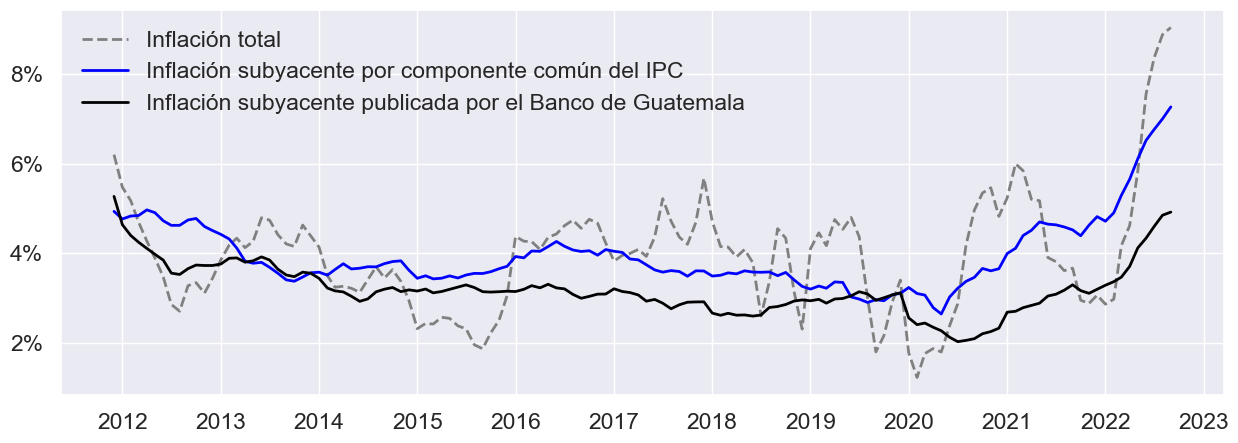

In [ ]:
slr=LinearRegression()

df_Ft = df_pc.multiply(y.std(),axis="columns").add(y.mean(),axis="columns")

y_reg=y.values.reshape(-1,1)
x_reg = df_Ft.iloc[:,0:3].values

df_estimacion = pd.DataFrame(slr.fit(x_reg,y_reg).predict(x_reg))
df_estimacion["Fecha"]=y.index
df_estimacion.set_index("Fecha",inplace=True)

plt.figure(figsize=(15, 5))
sns.set(font_scale=1.5)

plt.plot(y, color="grey", linestyle="--",linewidth=2) #Original
plt.plot(df_estimacion, color="blue",linewidth=2) #Alpha low
plt.plot(df_subyacente_banguat, color="black",linewidth=2) #Banguat


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())


plt.gca().get_yaxis().set_major_formatter(mtick.PercentFormatter(1,decimals=0))
plt.legend(["Inflación total","Inflación subyacente por componente común del IPC","Inflación subyacente publicada por el Banco de Guatemala"],loc="upper left")
plt.savefig(".\Graficas\graf_subyacente.jpg",bbox_inches='tight')

plt.show()

In [ ]:
# llevar estas series de tiempo a un excel

#with pd.ExcelWriter(output_file_path+"conjunto.xlsx", date_format="YYYY-MM-DD") as writer:
#    x.to_excel(writer, sheet_name="Series de tiempo")
#    y.to_excel(writer, sheet_name="Inflacion total")
#    df_subyacente_banguat.to_excel(writer, sheet_name="Inflacion subyacente Banguat")
#    df_estimacion.to_excel(writer, sheet_name="Inflacion subyacente estimada")

# expandiendo muestra mes a mes

In [ ]:
x.iloc[:127,:]

,1,2,3,4,5,6,7,8,9,10,11,12
Fecha,,,,,,,,,,,,
2011-12-01,0.120800,0.049700,0.029900,0.058400,0.030100,0.033700,0.059700,0.008300,0.021600,0.009100,0.046400,0.027900
2012-01-01,0.105506,0.046977,0.031195,0.050277,0.030527,0.031962,0.040151,0.006793,0.022986,0.011259,0.046649,0.027352
2012-02-01,0.098909,0.044657,0.030987,0.040054,0.032037,0.034100,0.040892,0.005088,0.024163,0.009421,0.046882,0.027591
2012-03-01,0.092694,0.044221,0.031969,0.018569,0.033134,0.034233,0.038761,0.002790,0.023144,0.007587,0.045219,0.028709
2012-04-01,0.085897,0.042492,0.032248,-0.000288,0.036096,0.032379,0.034925,0.000000,0.031352,0.005656,0.045034,0.030599
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-01,0.031939,0.022725,0.012450,0.035605,0.046883,0.015550,0.057989,-0.004657,0.017493,0.000660,0.033574,0.014625
2022-03-01,0.049155,0.026200,0.014845,0.051016,0.055450,0.017017,0.073983,-0.007244,0.015323,0.000754,0.043106,0.020480
2022-04-01,0.056213,0.033858,0.016254,0.036569,0.063735,0.017714,0.088362,-0.007870,0.025497,0.000848,0.047707,0.027651


C:\Users\Juan_Manuel\AppData\Local\Temp\ipykernel_14104\916772304.py:52: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm)
C:\Users\Juan_Manuel\AppData\Local\Temp\ipykernel_14104\916772304.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))


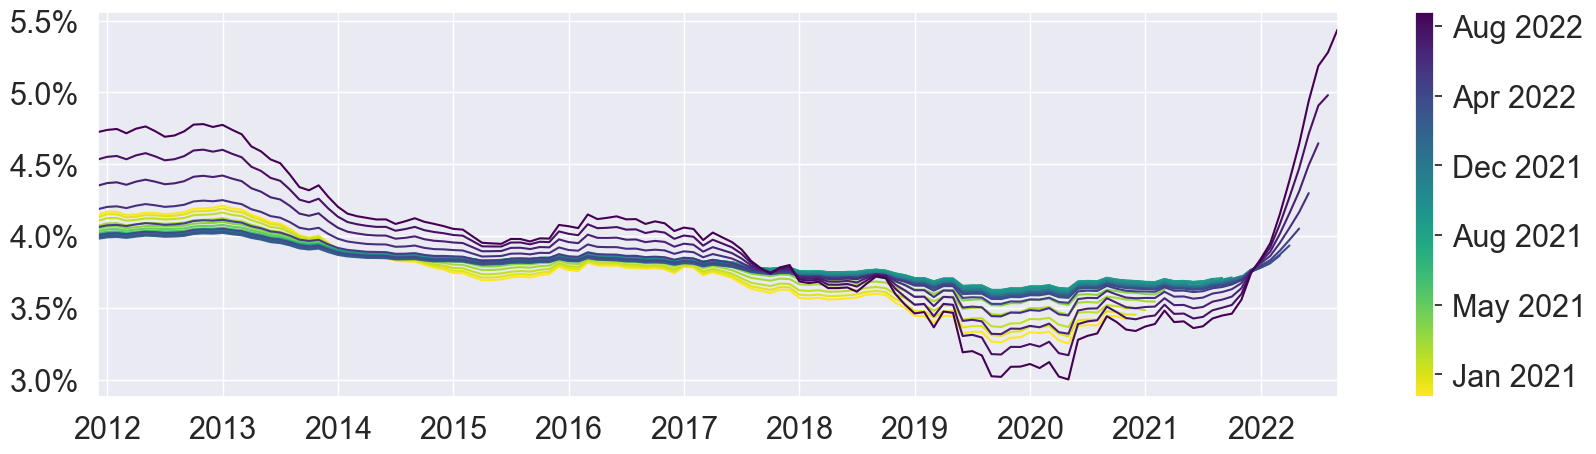

In [ ]:
start = 108
lista=[i for i in range(start,len(y)+1)]


diferencias_promedio = []
diferencias_max = []

df_curvas=pd.DataFrame(y)

#plt.figure(figsize=(10, 5))
#plt.plot(y, marker='o', color="b") #Original
#plt.plot(df_subyacente_banguat, marker='o', color="grey") #Banguat

#i=12
for i in lista:    
    x_norm = StandardScaler().fit_transform(x.iloc[:i,:])
    pca = decomposition.PCA(n_components=12) #max 12, por ser las observaciones, pero se obseva que con 4 componentes se puede obtener una buena aproximación
    pc=pca.fit_transform(x_norm)
    df_pc = pd.DataFrame(pc,columns=["PC"+str(i) for i in range(1,len(pca.components_)+1)])
    df_Ft = df_pc.iloc[:,0:1].multiply(y[:i].std(),axis="columns").add(y[:i].mean(),axis="columns")
    df_Ft["Fecha"]=y[:i].index
    df_Ft.set_index("Fecha",inplace=True)
    
    slr=LinearRegression()
    
    x_reg = df_Ft.values
    y_reg=y[:i].values.reshape(-1,1)
    df_estimacion_dir = pd.DataFrame(slr.fit(x_reg,y_reg).predict(x_reg))
    df_estimacion_dir["Fecha"]=df_Ft.index
    df_estimacion_dir.set_index("Fecha",inplace=True)

    diferencias_promedio.append((df_estimacion_dir - df_estimacion.iloc[:i,:]).apply(np.abs).values.mean())
    diferencias_max.append((df_estimacion_dir - df_estimacion.iloc[:i,:]).apply(np.abs).values.max())
    
    df_curvas["Curv"+str(i)]=df_estimacion_dir

    #df_curvas.iloc[:i,:]=df_estimacion_dir
    #plt.fill_between(df_estimacion_dir.iloc[:,:].index,df_estimacion_dir.iloc[:,:][0],df_estimacion.iloc[:i,:][0],color=colores[len(y)-i-1]) #Alpha low
    
    
    #plt.plot(df_estimacion_dir, color="grey",alpha=0.2) #Alpha low
#plt.axvspan(pd.to_datetime('2011-12-01'), pd.to_datetime('2022-06-30'),0.3,0.5, alpha=0.2, color='red')
df_curvas=df_curvas.drop(["0"],axis=1)



#plt.figure(figsize=(14, 7))
sns.set(font_scale=2)
sm = plt.cm.ScalarMappable(cmap="viridis_r", norm=plt.Normalize(vmin=df_curvas.index[start].value, vmax=df_curvas.index.max().value))
sm._A=[]
plot = df_curvas.plot(legend=False,cmap="viridis_r", figsize=(20, 5),xlabel="")
cbar=plt.colorbar(sm)
cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))
plt.gca().get_yaxis().set_major_formatter(mtick.PercentFormatter(1,decimals=1))




fig = plot.get_figure()





fig.savefig(".\Graficas\graf_subyacente_hist.jpg",bbox_inches='tight')
#plt.savefig()


In [ ]:
df_curvas

,Curv108,Curv109,Curv110,Curv111,Curv112,Curv113,Curv114,Curv115,Curv116,Curv117,...,Curv121,Curv122,Curv123,Curv124,Curv125,Curv126,Curv127,Curv128,Curv129,Curv130
Fecha,,,,,,,,,,,,,,,,,,,,,
2011-12-01,0.041467,0.041297,0.041047,0.040709,0.040501,0.040334,0.040189,0.040134,0.040094,0.040073,...,0.039990,0.039905,0.039804,0.039874,0.040055,0.040615,0.041866,0.043503,0.045329,0.047235
2012-01-01,0.041693,0.041516,0.041247,0.040883,0.040652,0.040466,0.040303,0.040241,0.040197,0.040173,...,0.040093,0.040009,0.039909,0.039983,0.040171,0.040748,0.042028,0.043688,0.045514,0.047386
2012-02-01,0.041689,0.041513,0.041252,0.040896,0.040670,0.040485,0.040323,0.040263,0.040220,0.040197,...,0.040124,0.040039,0.039937,0.040010,0.040197,0.040778,0.042069,0.043740,0.045574,0.047453
2012-03-01,0.041450,0.041292,0.041063,0.040746,0.040547,0.040381,0.040238,0.040185,0.040147,0.040128,...,0.040058,0.039974,0.039872,0.039942,0.040124,0.040691,0.041947,0.043569,0.045344,0.047154
2012-04-01,0.041516,0.041355,0.041130,0.040814,0.040615,0.040447,0.040301,0.040250,0.040214,0.040197,...,0.040143,0.040061,0.039961,0.040034,0.040225,0.040812,0.042113,0.043789,0.045617,0.047474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.040518,0.041658,0.043102,0.044701,0.046384
2022-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.042986,0.044934,0.047105,0.049401
2022-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.046456,0.049079,0.051844


In [ ]:
np.array(diferencias_promedio).max()*100

#diferencias_promedio.index(np.array(diferencias_promedio).max())

0.4206157255018413

In [ ]:
np.array(diferencias_promedio).mean()*100

0.36840290986457175

In [ ]:
np.array(diferencias_max).mean()*100

1.2587776043801067

In [ ]:
np.array(diferencias_max).max()*100

2.220046753454387

In [ ]:
diferencias_max.index(np.array(diferencias_max).max())

19

In [ ]:
df_test = df_curvas.iloc[:start+6,6:6+1]
df_test.columns=[0]
df_test

,0
Fecha,
2011-12-01,0.040189
2012-01-01,0.040303
2012-02-01,0.040323
2012-03-01,0.040238
2012-04-01,0.040301
...,...
2021-01-01,0.036672
2021-02-01,0.036651
2021-03-01,0.036898


In [ ]:
dif=(df_estimacion.iloc[:start+6,:]-df_test).apply(np.abs)

In [ ]:
dif[0].max()

0.010201094577658693

In [ ]:
dif[(dif[0]==np.array(diferencias_max).max())]

,0
Fecha,


In [ ]:
df_curvas.loc["2020-05-01"]["Curv114"]

0.036131421302612626

In [ ]:
df_estimacion.loc["2020-05-01"].values[0]

0.026502764340201844

In [ ]:
df_curvas.loc["2020-05-01"]["Curv114"]-df_estimacion.loc["2020-05-01"].values[0]

0.009628656962410782

In [ ]:
from datetime import datetime


datetime.strptime("2020-05-01",'%Y-%m-%d')

datetime.datetime(2020, 5, 1, 0, 0)

C:\Users\Juan_Manuel\AppData\Local\Temp\ipykernel_14104\2826486227.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "co" (-> color='c'). The keyword argument will take precedence.
  plt.plot(pd.to_datetime('2020-05-01'), 0.0329, "co", color ="blue" ,markersize=15)
C:\Users\Juan_Manuel\AppData\Local\Temp\ipykernel_14104\2826486227.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "co" (-> color='c'). The keyword argument will take precedence.
  plt.plot(pd.to_datetime('2020-05-01'), 0.0363, "co", color ="blue" ,markersize=15)


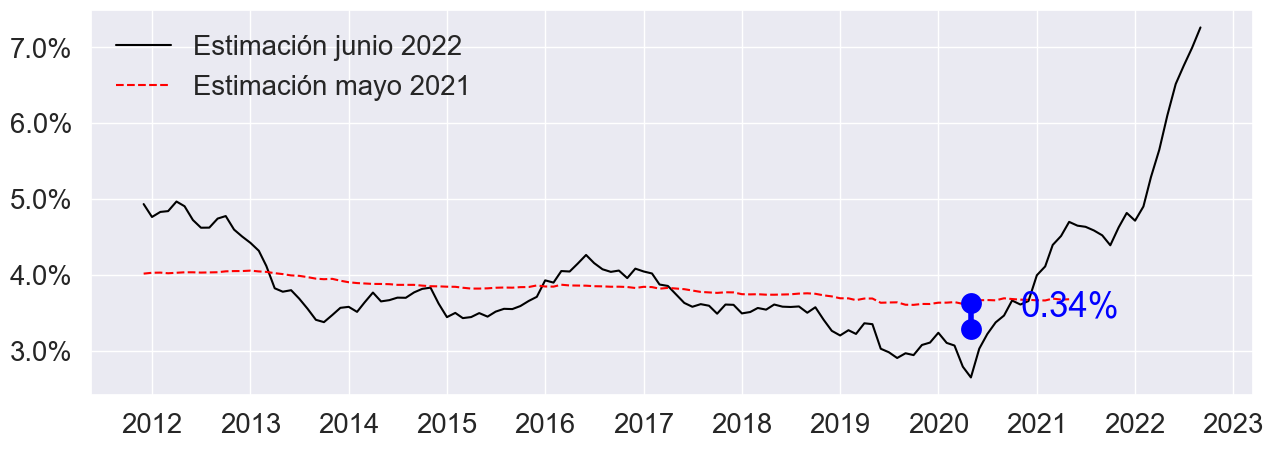

In [ ]:

from datetime import datetime

plt.figure(figsize=(15, 5))
sns.set(font_scale=1.8)


plt.plot(df_estimacion.iloc[:,:], color="black") #Alpha low
plt.plot(df_curvas.iloc[:,6:6+1], color="red", linestyle='--') #Alpha low


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
#plt.gcf().autofmt_xdate()
plt.gca().get_yaxis().set_major_formatter(mtick.PercentFormatter(1,decimals=1))

plt.vlines(pd.to_datetime('2020-05-01'), 0.0329, 0.0363, color='blue', linewidth=4)#,ymin=0.07,ymax=0.39)
plt.plot(pd.to_datetime('2020-05-01'), 0.0329, "co", color ="blue" ,markersize=15)
plt.plot(pd.to_datetime('2020-05-01'), 0.0363, "co", color ="blue" ,markersize=15)

#plt.axvline(pd.to_datetime('2020-05-01'), color='blue')#,ymin=0.07,ymax=0.39)

plt.legend(["Estimación junio 2022","Estimación mayo 2021"],loc="upper left")
plt.text(pd.to_datetime('2020-11-01'), 0.0345, "0.34%",color="blue", fontsize=25)
plt.xticks(rotation="horizontal")
#plt.gcf().autofmt_xdate()


plt.savefig(".\Graficas\suby 05-2021 y 06-2022.jpg",bbox_inches='tight')
#plt.legend(["0.36%"],loc="upper right")


plt.show()

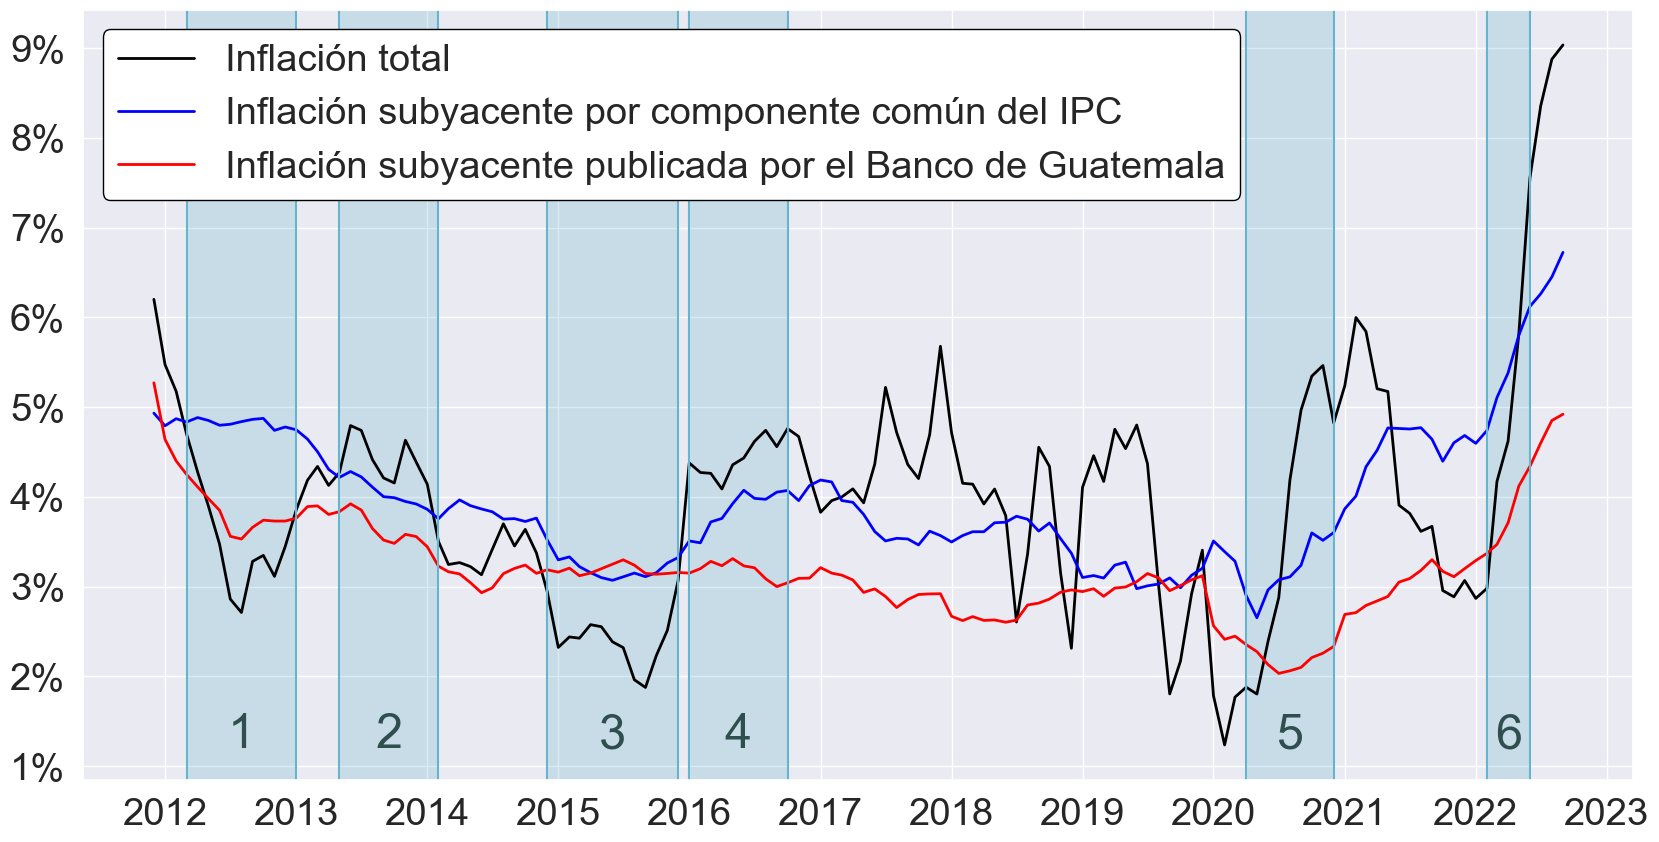

In [ ]:
slr=LinearRegression()

df_Ft = df_pc.multiply(y.std(),axis="columns").add(y.mean(),axis="columns")

y_reg=y.values.reshape(-1,1)
x_reg = df_Ft.iloc[:,0:2].values

df_estimacion = pd.DataFrame(slr.fit(x_reg,y_reg).predict(x_reg))
df_estimacion["Fecha"]=y.index
df_estimacion.set_index("Fecha",inplace=True)

plt.figure(figsize=(20, 10))
sns.set(font_scale=2.5)

plt.plot(y, color="black",linewidth=2)#, linestyle="--") #Original
plt.plot(df_estimacion, color="blue",linewidth=2) #Alpha low
plt.plot(df_subyacente_banguat, color="red",linewidth=2) #Banguat


#plt.axhline(y=0.03, color='red', linestyle='--')
#plt.axhline(y=0.05, color='red', linestyle='--')
#plt.axhspan(0.03, 0.05, facecolor='red', alpha=0.05)


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

#plt.axvline(pd.to_datetime('2019-01-01'), color='grey')#,ymin=0.07,ymax=0.39)
#plt.axvline(pd.to_datetime('2020-05-01'), color='grey')
#plt.axvspan(pd.to_datetime('2019-01-01'), pd.to_datetime('2020-05-01'), facecolor='grey', alpha=0.25)


parejas_fecha = [['2012-03-01','2013-01-01'],['2013-05-01','2014-02-01'],['2014-12-01','2015-12-01'],['2016-01-01','2016-10-01'],['2020-04-01','2020-12-01'],['2022-02-01','2022-06-01']]

def fecha_media(lista):
    mean = (np.array(lista, dtype='datetime64[s]')
        .view('i8')
        .mean()
        .astype('datetime64[s]'))
    return mean
numero_pareja=0
for fechas in parejas_fecha:
    numero_pareja+=1
    plt.axvline(pd.to_datetime(fechas[0]), color='c')#,ymin=0.07,ymax=0.39)
    plt.axvline(pd.to_datetime(fechas[1]), color='c')
    plt.axvspan(pd.to_datetime(fechas[0]), pd.to_datetime(fechas[1]), facecolor='c', alpha=0.25)
    plt.text(pd.to_datetime(fecha_media(fechas)), 0.012, str(numero_pareja),color="darkslategrey", fontsize=35,horizontalalignment='center')





plt.gca().get_yaxis().set_major_formatter(mtick.PercentFormatter(1,decimals=0))
plt.legend(["Inflación total","Inflación subyacente por componente común del IPC","Inflación subyacente publicada por el Banco de Guatemala"],loc="upper left",frameon=True, facecolor="white", edgecolor="black", framealpha=1)
plt.savefig(".\Graficas\choques.jpg",bbox_inches='tight')

plt.show()

In [ ]:

date = ['2016-02-23', '2016-02-24']
mean = (np.array(date, dtype='datetime64[s]')
        .view('i8')
        .mean()
        .astype('datetime64[s]'))

print(mean)

2016-02-23T12:00:00


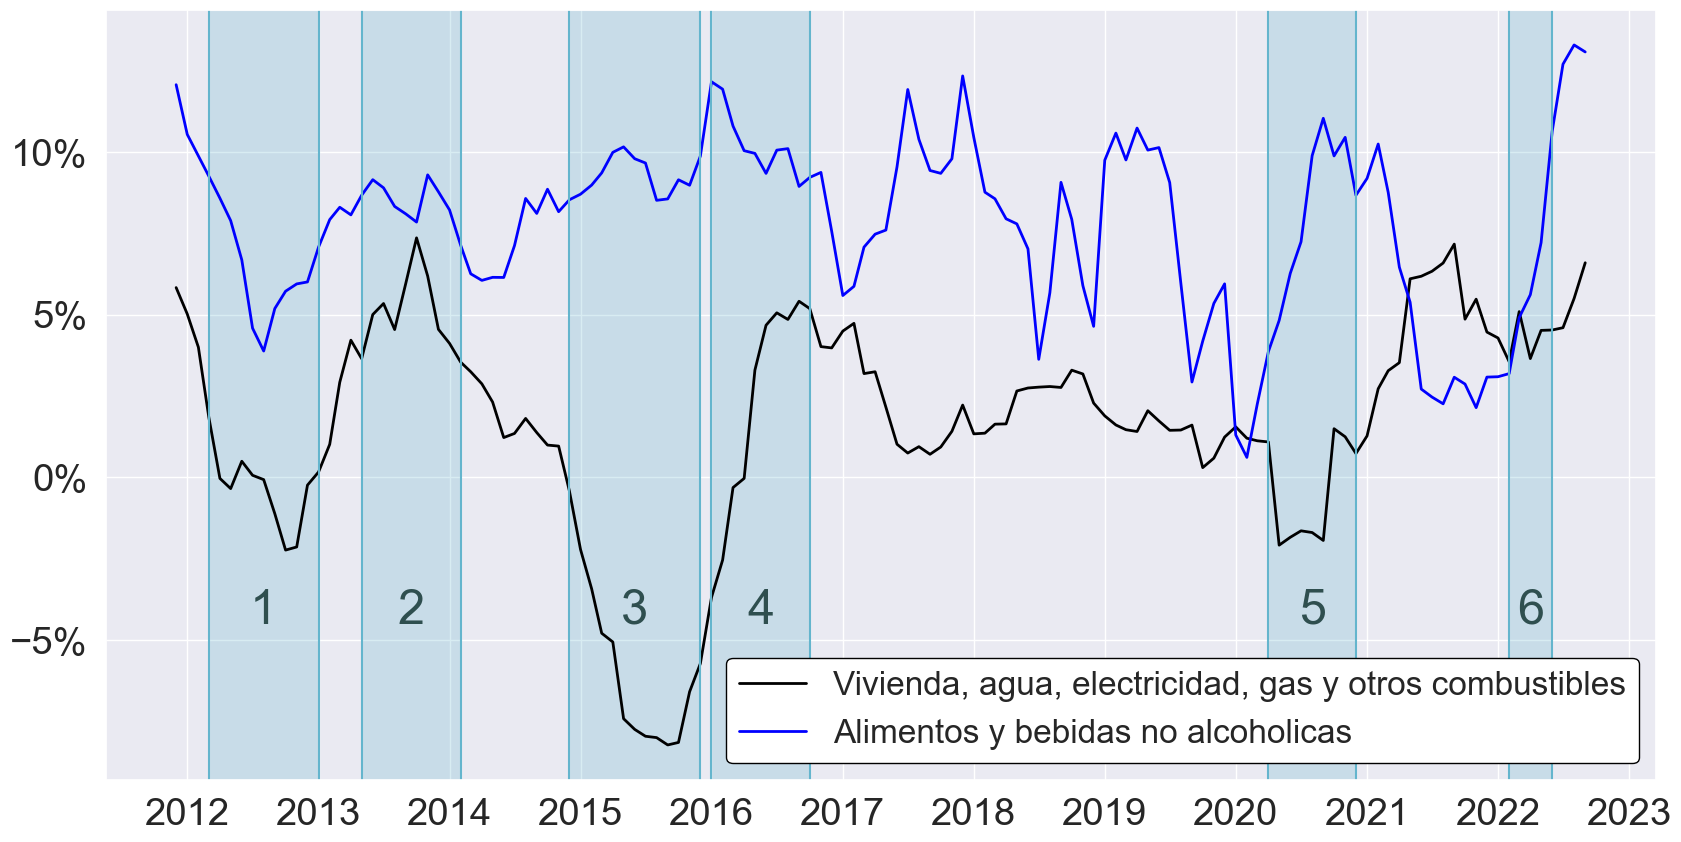

In [ ]:
orden_volatilidad = list(x.std().sort_values().index)
orden_volatilidad = orden_volatilidad[::-1]


orden_volatilidad_int = [int(i) for i in orden_volatilidad]
nombres_orden=list(df_Codigos.loc[orden_volatilidad_int]["DESCRIPCION"].values)

plt.figure(figsize=(20, 10))
sns.set(font_scale=2.5)

plt.plot(x[orden_volatilidad[1]], color="black",linewidth=2)#, linestyle="--") #Original
plt.plot(x[orden_volatilidad[2]], color="blue",linewidth=2) #Alpha low
#plt.plot(df_subyacente_banguat, color="red",linewidth=2) #Banguat


#plt.axhline(y=0.03, color='red', linestyle='--')
#plt.axhline(y=0.05, color='red', linestyle='--')
#plt.axhspan(0.03, 0.05, facecolor='red', alpha=0.05)


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

#plt.axvline(pd.to_datetime('2019-01-01'), color='grey')#,ymin=0.07,ymax=0.39)
#plt.axvline(pd.to_datetime('2020-05-01'), color='grey')
#plt.axvspan(pd.to_datetime('2019-01-01'), pd.to_datetime('2020-05-01'), facecolor='grey', alpha=0.25)


parejas_fecha = [['2012-03-01','2013-01-01'],['2013-05-01','2014-02-01'],['2014-12-01','2015-12-01'],['2016-01-01','2016-10-01'],['2020-04-01','2020-12-01'],['2022-02-01','2022-06-01']]
numero_pareja=0
for fechas in parejas_fecha:
    numero_pareja+=1
    plt.axvline(pd.to_datetime(fechas[0]), color='c')#,ymin=0.07,ymax=0.39)
    plt.axvline(pd.to_datetime(fechas[1]), color='c')
    plt.axvspan(pd.to_datetime(fechas[0]), pd.to_datetime(fechas[1]), facecolor='c', alpha=0.25)
    plt.text(pd.to_datetime(fecha_media(fechas)), -0.045, str(numero_pareja),color="darkslategrey", fontsize=35,horizontalalignment='center')


plt.legend(["Vivienda, agua, electricidad, gas y otros combustibles","Alimentos y bebidas no alcoholicas"],fontsize=24,loc="lower right",frameon=True, facecolor="white", edgecolor="black", framealpha=1)


plt.gca().get_yaxis().set_major_formatter(mtick.PercentFormatter(1,decimals=0))

plt.savefig(".\Graficas\choques_petroleo_alimentos.jpg",bbox_inches='tight')

plt.show()

# Comparación brecha del producto

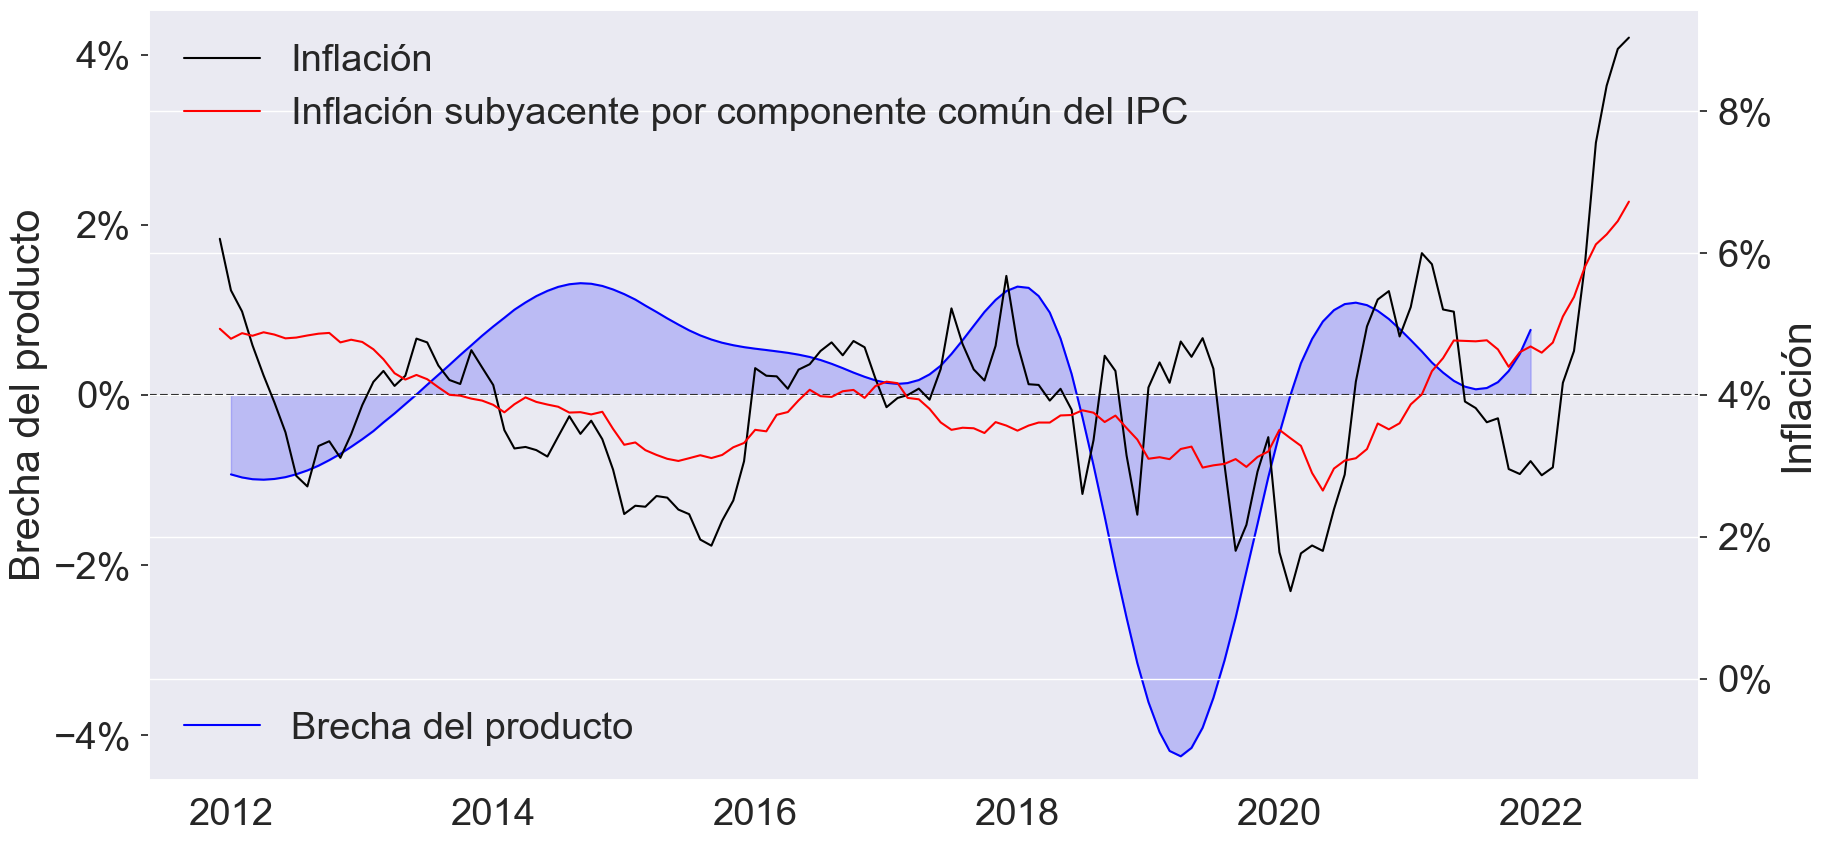

In [ ]:
df_PIB_IMF=pd.read_excel("./PIB/PIB IMF CONSTANT PRICES.xlsx")
df_PIB_IMF["Fecha"]= pd.PeriodIndex(df_PIB_IMF["Fecha"], freq='A').to_timestamp()
df_PIB_IMF.set_index("Fecha", inplace=True)


#ESCOGIENDO LOS DATOS PARA HACER LA REGRESIÓN POLINOMIAL
df_PIB = df_PIB_IMF.loc["2012-01-01":"2023-01-01"].copy()

#REALIZANDO LA REGRESIÓN POLINOMIAL
x_reg = np.array([i+1 for i in range(len(df_PIB))]).reshape(-1,1)
y_reg = df_PIB["PIB"].values.reshape(-1,1)

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(x_reg.reshape(-1, 1))
y_predict = slr.fit(poly_features, y_reg).predict(poly_features)

#OBTENIENDO LA BRECHA DEL PRODUCTO 
df_PIB["PIB_pot"]=y_predict
df_PIB["Brecha"]=df_PIB["PIB"]-df_PIB["PIB_pot"]
df_PIB["Brecha_porcentual"]=df_PIB["Brecha"]/df_PIB["PIB"]

#DELIMITANDO LOS DATOS A USAR PARA GRÁFICAR
df_PIB_Gf =df_PIB.loc[df_estimacion.index.min():]

#INTERPOLACIÓN DE LOS DATOS QUE SE GRAFICARAN
from scipy.interpolate import interp1d
x_interpol= np.array([i+1 for i in range(0,len(df_PIB_Gf))])
cubic_interploation_model = interp1d(x_interpol, df_PIB_Gf["Brecha_porcentual"], kind = "cubic")
X_=np.linspace(x_interpol.min(), x_interpol.max(), 120)
Y_=cubic_interploation_model(X_)

df_PIB_suav = pd.DataFrame({"X":X_,"PIB_PORC":Y_})


#GRAFICANDO LA BRECHA DEL PRODUCTO SUAVIZADA JUNTO INFLACION TOTAL Y SUBYACENTE
sns.set(font_scale=2.5)
fig, ax1 = plt.subplots(figsize=(20, 10))



ax2 = ax1.twinx()

ax1.plot(df_estimacion.iloc[1:121,:].index, Y_, color='blue')
ax1.axhline(y=0, color='black', linestyle='--')
ax1.fill_between(df_estimacion.iloc[1:121,:].index, 0, Y_, color='blue', alpha=0.2)

ax2.plot(y, color='black')
ax2.plot(df_estimacion, color='red')

yabs1_max = abs(max(ax1.get_ylim(), key=abs))
ax1.set_ylim(ymin=-yabs1_max, ymax=yabs1_max)

yabs2_max = abs(max(ax2.get_ylim(), key=abs))
ax2.set_ylim(ymin=0.08-yabs2_max, ymax=yabs2_max)
#ax2.grid(False)
ax1.grid(False)
#ax2.grid(True)



ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0))
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0))
ax1.set_ylabel("Brecha del producto")
ax2.set_ylabel("Inflación")


ax1.legend(["Brecha del producto"],loc="lower left")
ax2.legend(["Inflación","Inflación subyacente por componente común del IPC"],loc="upper left")
plt.show()

fig.savefig(".\Graficas\graf_brecha.jpg",bbox_inches='tight')


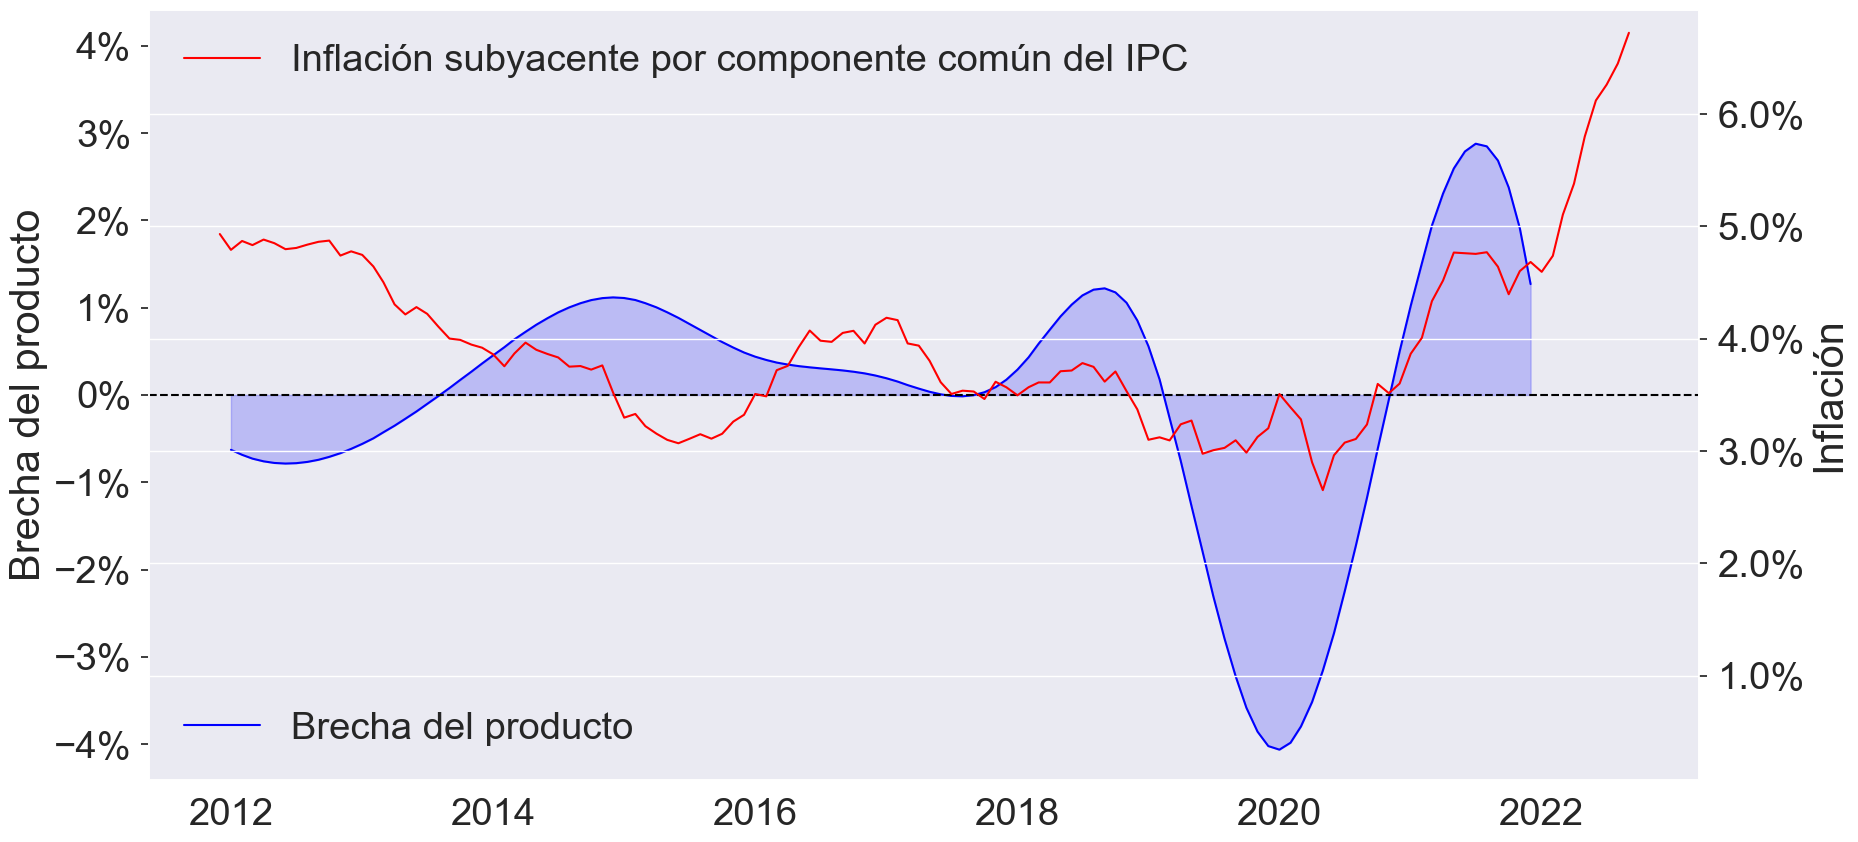

In [ ]:
df_PIB_IMF=pd.read_excel("./PIB/PIB IMF CONSTANT PRICES.xlsx")
df_PIB_IMF["Fecha"]= pd.PeriodIndex(df_PIB_IMF["Fecha"], freq='A').to_timestamp()
df_PIB_IMF.set_index("Fecha", inplace=True)


#ESCOGIENDO LOS DATOS PARA HACER LA REGRESIÓN POLINOMIAL
df_PIB = df_PIB_IMF.loc["2012-01-01":"2022-01-01"].copy()

#REALIZANDO LA REGRESIÓN POLINOMIAL
x_reg = np.array([i+1 for i in range(len(df_PIB))]).reshape(-1,1)
y_reg = df_PIB["PIB"].values.reshape(-1,1)

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(x_reg.reshape(-1, 1))
y_predict = slr.fit(poly_features, y_reg).predict(poly_features)

#OBTENIENDO LA BRECHA DEL PRODUCTO 
df_PIB["PIB_pot"]=y_predict
df_PIB["Brecha"]=df_PIB["PIB"]-df_PIB["PIB_pot"]
df_PIB["Brecha_porcentual"]=df_PIB["Brecha"]/df_PIB["PIB"]

#DELIMITANDO LOS DATOS A USAR PARA GRÁFICAR
df_PIB_Gf =df_PIB.loc[df_estimacion.index.min():]

#INTERPOLACIÓN DE LOS DATOS QUE SE GRAFICARAN
from scipy.interpolate import interp1d
x_interpol= np.array([i+1 for i in range(0,len(df_PIB_Gf))])
cubic_interploation_model = interp1d(x_interpol, df_PIB_Gf["Brecha_porcentual"], kind = "cubic")
X_=np.linspace(x_interpol.min(), x_interpol.max(), 120)
Y_=cubic_interploation_model(X_)

df_PIB_suav = pd.DataFrame({"X":X_,"PIB_PORC":Y_})


#GRAFICANDO LA BRECHA DEL PRODUCTO SUAVIZADA JUNTO INFLACION TOTAL Y SUBYACENTE
sns.set(font_scale=2.5)
fig, ax1 = plt.subplots(figsize=(20, 10))



ax2 = ax1.twinx()

ax1.plot(df_estimacion.iloc[1:121,:].index, Y_, color='blue')
ax1.axhline(y=0, color='black', linestyle='--')
ax1.fill_between(df_estimacion.iloc[1:121,:].index, 0, Y_, color='blue', alpha=0.2)

#ax2.plot(y, color='black')
ax2.plot(df_estimacion, color='red')

yabs1_max = abs(max(ax1.get_ylim(), key=abs))
ax1.set_ylim(ymin=-yabs1_max, ymax=yabs1_max)

yabs2_max = abs(max(ax2.get_ylim(), key=abs))
#ax2.set_ylim(ymin=0.08-yabs2_max, ymax=yabs2_max)
ax2.set_ylim(ymin=0.07-yabs2_max, ymax=yabs2_max)
#ax2.grid(False)
ax1.grid(False)
#ax2.grid(True)



ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0))
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=1))
ax1.set_ylabel("Brecha del producto")
ax2.set_ylabel("Inflación")


ax1.legend(["Brecha del producto"],loc="lower left")
#ax2.legend(["Inflación","Inflación subyacente por componente común del IPC"],loc="upper left")
ax2.legend(["Inflación subyacente por componente común del IPC"],loc="upper left")
plt.show()

fig.savefig(".\Graficas\graf_brecha.jpg",bbox_inches='tight')